In [1]:
from torch import nn
import torch
import numpy
import os
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from random import sample
import soundfile as sf
import matplotlib.pyplot as plt
import librosa
import numpy as np
from sklearn.utils import class_weight

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
whisper_version = 'openai/whisper-small'

In [3]:
from transformers import WhisperProcessor, WhisperFeatureExtractor

feature_extractor = WhisperFeatureExtractor.from_pretrained(whisper_version)
processor = WhisperProcessor.from_pretrained(whisper_version)

It is strongly recommended to pass the `sampling_rate` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Audio length = 0.495125 sec
[[-1.1968606  -1.0316894  -1.075866   ... -1.1968606  -1.1968606
  -1.1968606 ]
 [-1.1248713  -0.9133804  -1.079752   ... -1.1968606  -1.1968606
  -1.1968606 ]
 [-1.1266394  -0.86591876 -1.1504135  ... -1.1968606  -1.1968606
  -1.1968606 ]
 ...
 [-1.0043597  -0.8534584  -0.8485029  ... -1.1968606  -1.1968606
  -1.1968606 ]
 [-0.803141   -0.8701279  -0.91528785 ... -1.1968606  -1.1968606
  -1.1968606 ]
 [-0.8117651  -0.9013684  -0.92064464 ... -1.1968606  -1.1968606
  -1.1968606 ]]


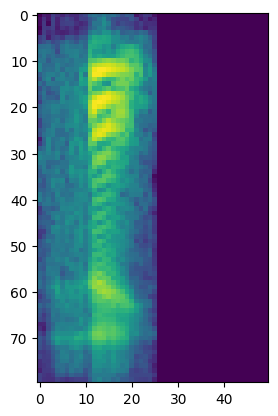

In [4]:
test_audio_path = 'datasets/alphadigit_letters/c/AD-2101.p3_1.wav'
data, sr = sf.read(test_audio_path)
print(f'Audio length = {len(data)/sr} sec')
features = feature_extractor(data)['input_features'][0]
plt.imshow(features[:, :50])
print(features)

In [5]:
def feature_end(feature_tensor):
    equal_to_first = torch.all(torch.eq(feature_tensor, feature_tensor[0]), dim=0)
    
    first_index = torch.nonzero(equal_to_first)[0]
    
    return first_index.item() if first_index.numel() > 0 else -1

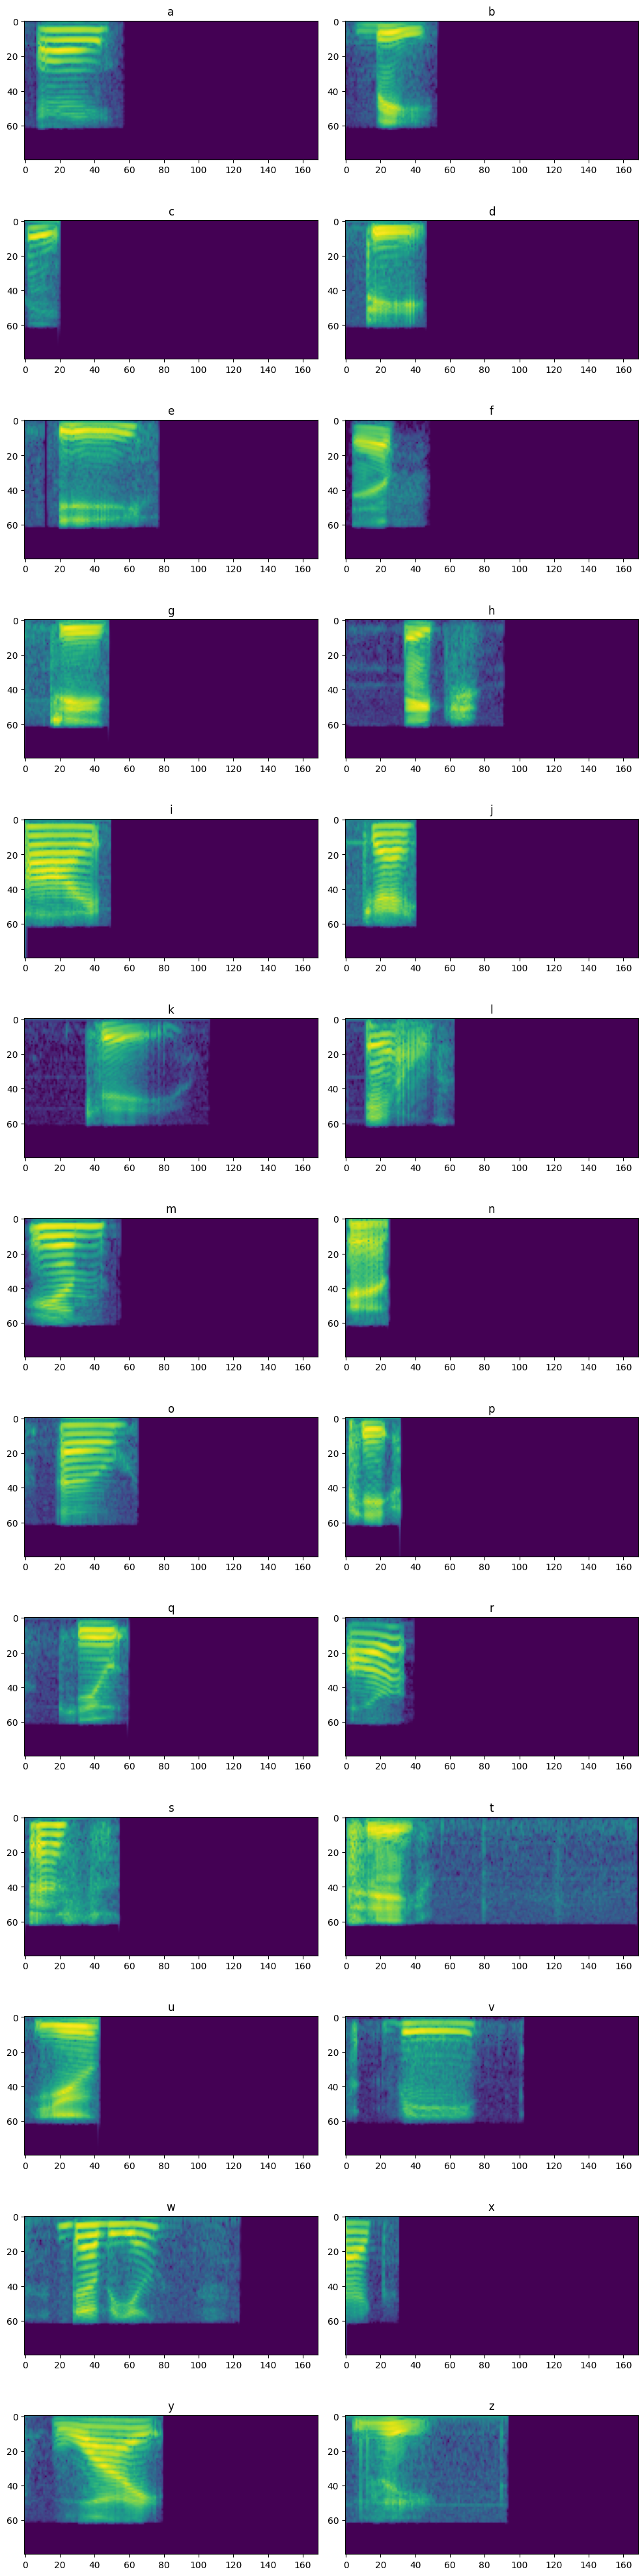

In [6]:
folder_dir = 'datasets/alphadigit_letters'
num_class = len(os.listdir(folder_dir))
fig, axes = plt.subplots(13, 2, figsize=(10,40))
labeled_features = []
length = 0
for subdir in os.listdir(folder_dir):
    subdir_path = os.path.join(folder_dir, subdir)
    test_file = sample(list(os.listdir(subdir_path)), 1)[0]
    file_path = os.path.join(subdir_path, test_file)
    
    data, sr = sf.read(file_path)
    if sr != 16000:
        data = librosa.resample(data, orig_sr=sr, target_sr=16000)
        sr = 16000
    features = feature_extractor(data, sampling_rate=sr)['input_features'][0]
    labeled_features.append((subdir, features))
    length = max(length, feature_end(torch.tensor(features[:, :1000])))

for idx, labeled_feature in enumerate(labeled_features):
    axes[int(idx/2)][idx%2].imshow(labeled_feature[1][:, :length])
    axes[int(idx/2)][idx%2].set_title(labeled_feature[0])
    
plt.tight_layout()

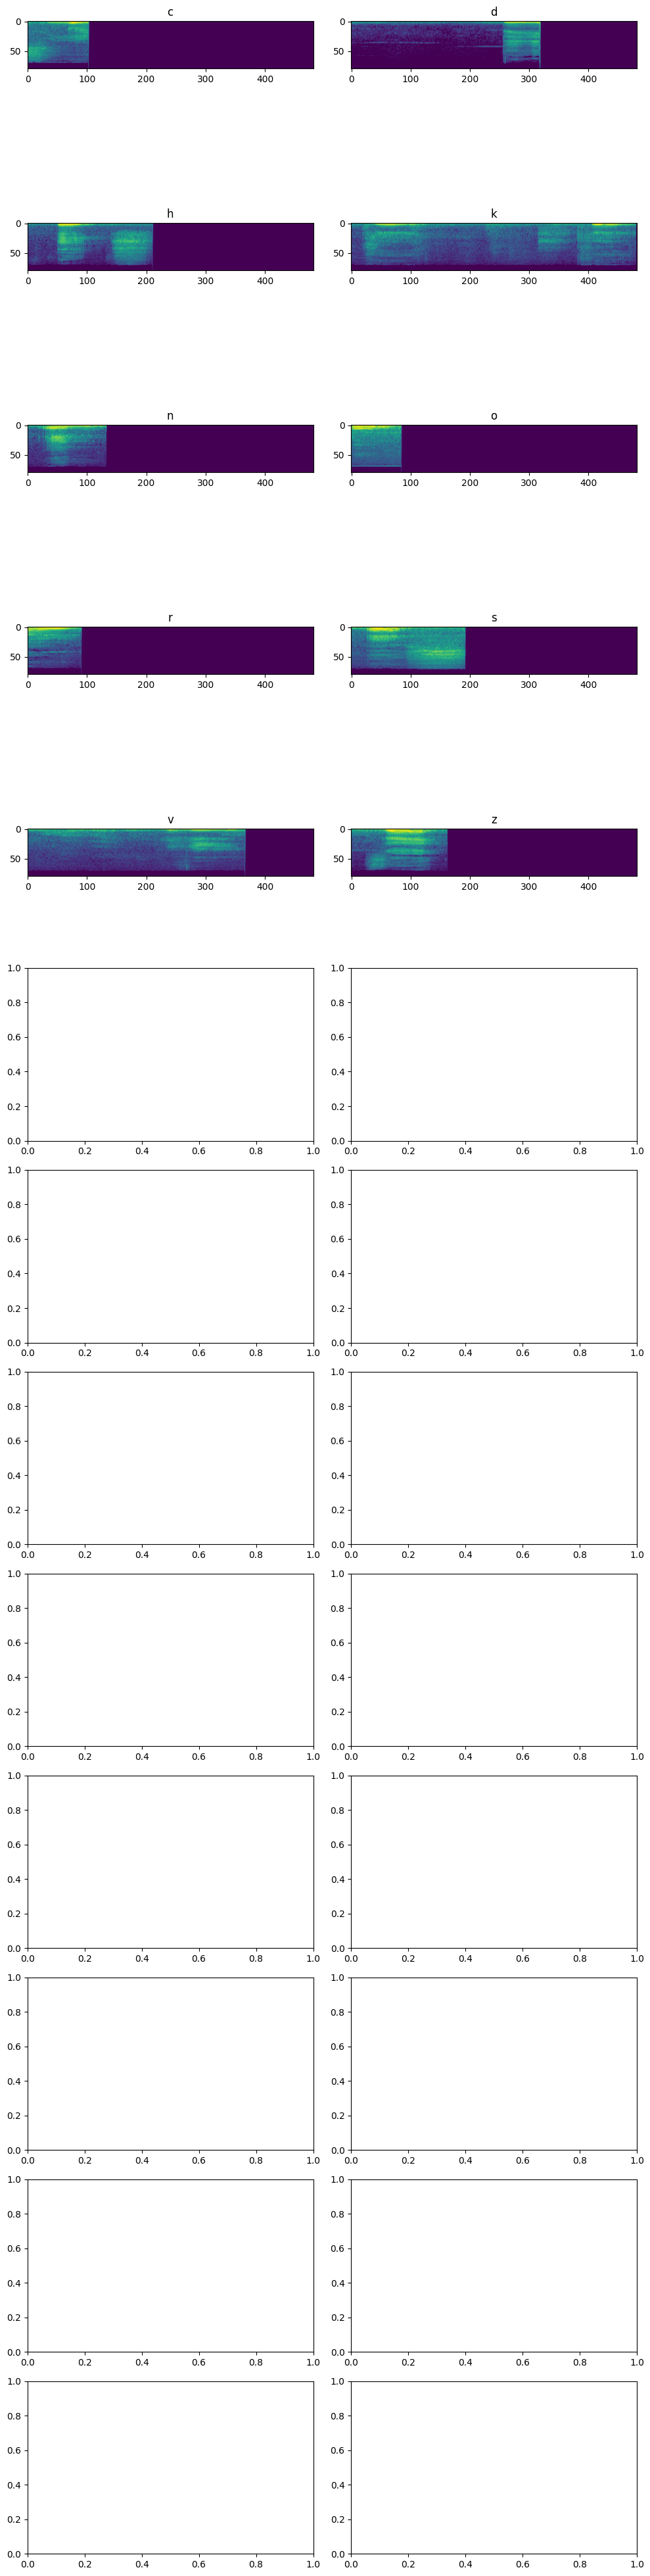

In [7]:
folder_dir = 'datasets/local_sloans'
num_class = len(os.listdir(folder_dir))
fig, axes = plt.subplots(13, 2, figsize=(10,40))
labeled_features = []
length = 0
for subdir in os.listdir(folder_dir):
    subdir_path = os.path.join(folder_dir, subdir)
    test_file = sample(list(os.listdir(subdir_path)), 1)[0]
    file_path = os.path.join(subdir_path, test_file)
    
    data, sr = sf.read(file_path)
    if sr != 16000:
        data = librosa.resample(data, orig_sr=sr, target_sr=16000)
        sr = 16000
    data = data.flatten()
    features = feature_extractor(data, sampling_rate=sr)['input_features'][0]
    labeled_features.append((subdir, features))
    length = max(length, feature_end(torch.tensor(features[:, :1000])))

for idx, labeled_feature in enumerate(labeled_features):
    axes[int(idx/2)][idx%2].imshow(labeled_feature[1][:, :length])
    axes[int(idx/2)][idx%2].set_title(labeled_feature[0])
    
plt.tight_layout()

In [7]:
CUT_OFF = 150

In [8]:
from transformers import WhisperForAudioClassification

model = WhisperForAudioClassification.from_pretrained(whisper_version)
model

Some weights of WhisperForAudioClassification were not initialized from the model checkpoint at openai/whisper-small and are newly initialized: ['model.classifier.bias', 'model.projector.bias', 'model.classifier.weight', 'model.projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


WhisperForAudioClassification(
  (encoder): WhisperEncoder(
    (conv1): Conv1d(80, 768, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv2): Conv1d(768, 768, kernel_size=(3,), stride=(2,), padding=(1,))
    (embed_positions): Embedding(1500, 768)
    (layers): ModuleList(
      (0-11): 12 x WhisperEncoderLayer(
        (self_attn): WhisperAttention(
          (k_proj): Linear(in_features=768, out_features=768, bias=False)
          (v_proj): Linear(in_features=768, out_features=768, bias=True)
          (q_proj): Linear(in_features=768, out_features=768, bias=True)
          (out_proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (activation_fn): GELUActivation()
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (final_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_af

In [9]:
model.classifier = nn.Linear(in_features=256, out_features=11, bias=True)

In [10]:
model = model.cuda()
random_input = torch.randn(1, 80, 3000).cuda()

In [11]:
model(random_input)

SequenceClassifierOutput(loss=None, logits=tensor([[-0.0579,  0.1511,  0.5736, -0.2215,  0.3588,  0.4178,  0.1638, -0.5644,
          0.3062,  0.0653, -0.0401]], device='cuda:0',
       grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [12]:
original_embedding_weights = model.encoder.embed_positions.weight.data
new_embedding = nn.Embedding(int(CUT_OFF/2), 768)
new_embedding.weight.data.copy_(original_embedding_weights[:int(CUT_OFF/2), :])
model.encoder.embed_positions = new_embedding

In [13]:
model

WhisperForAudioClassification(
  (encoder): WhisperEncoder(
    (conv1): Conv1d(80, 768, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv2): Conv1d(768, 768, kernel_size=(3,), stride=(2,), padding=(1,))
    (embed_positions): Embedding(75, 768)
    (layers): ModuleList(
      (0-11): 12 x WhisperEncoderLayer(
        (self_attn): WhisperAttention(
          (k_proj): Linear(in_features=768, out_features=768, bias=False)
          (v_proj): Linear(in_features=768, out_features=768, bias=True)
          (q_proj): Linear(in_features=768, out_features=768, bias=True)
          (out_proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (activation_fn): GELUActivation()
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (final_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affi

In [14]:
model = model.cuda()
model(random_input[:, :, :CUT_OFF])

SequenceClassifierOutput(loss=None, logits=tensor([[-0.1271,  0.2385, -0.0246, -0.1515,  0.8918,  0.1557, -0.1656, -0.3674,
          0.4365,  0.1972, -0.0645]], device='cuda:0',
       grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [15]:
model

WhisperForAudioClassification(
  (encoder): WhisperEncoder(
    (conv1): Conv1d(80, 768, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv2): Conv1d(768, 768, kernel_size=(3,), stride=(2,), padding=(1,))
    (embed_positions): Embedding(75, 768)
    (layers): ModuleList(
      (0-11): 12 x WhisperEncoderLayer(
        (self_attn): WhisperAttention(
          (k_proj): Linear(in_features=768, out_features=768, bias=False)
          (v_proj): Linear(in_features=768, out_features=768, bias=True)
          (q_proj): Linear(in_features=768, out_features=768, bias=True)
          (out_proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (activation_fn): GELUActivation()
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (final_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affi

In [16]:
for param in model.encoder.parameters():
    param.requires_grad = False

In [17]:
class AudioDataset(Dataset):

    def __init__(self, folder_dir=None, selected_labels=None, num_samples=None):
        super().__init__()
        if folder_dir is None or selected_labels is None or num_samples is None:
            return
        labels = os.listdir(folder_dir)
        
        self.label2class = dict()
        self.class2label = dict()
        
        self.samples = []
        self.class_count = np.zeros(len(selected_labels)+1)
        
        for idx, selected_label in enumerate(tqdm(selected_labels, desc='Processing Selected Classes')):
            self.label2class[selected_label] = idx
            self.class2label[idx] = selected_label
            
            label_folder_path = os.path.join(folder_dir, selected_label)

            if num_samples > len(list(os.listdir(label_folder_path))):
                num_samples_local = len(list(os.listdir(label_folder_path)))
            else:
                num_samples_local = num_samples
            
            selected_audio_files = sample(list(os.listdir(label_folder_path)), num_samples_local)

            for selected_audio_file in selected_audio_files:
                print(selected_audio_file)
                file_path = os.path.join(label_folder_path, selected_audio_file)
                data, sr = sf.read(file_path)
                
                if sr != 16000:
                    data = librosa.resample(data, orig_sr=sr, target_sr=16000)
                    sr = 16000
                data = data.flatten()
                features = feature_extractor(data, sampling_rate=sr)
                feature_length = feature_end(torch.tensor(features['input_features'][0]))
                
                segmented_features = features['input_features'][0][:, :CUT_OFF]
                self.samples.append({
                    'features': torch.tensor(segmented_features).cuda(),
                    'class_id': torch.tensor(idx).cuda(),
                })
                self.class_count[idx] += 1
        
        remaining_labels = [x for x in labels if x not in selected_labels]
        for remaining_label in tqdm(remaining_labels, desc='Processing Misc. Class'):
            self.label2class['other'] = len(selected_label)
            self.class2label[len(selected_label)] = 'other'
            
            label_folder_path = os.path.join(folder_dir, remaining_label)

            if num_samples > len(list(os.listdir(label_folder_path))):
                num_samples_local = len(list(os.listdir(label_folder_path)))
            else:
                num_samples_local = num_samples
            
            selected_audio_files = sample(list(os.listdir(label_folder_path)), num_samples_local)

            for selected_audio_file in selected_audio_files:
                file_path = os.path.join(label_folder_path, selected_audio_file)
                data, sr = sf.read(file_path)
                
                if sr != 16000:
                    data = librosa.resample(data, orig_sr=sr, target_sr=16000)
                    sr = 16000
                data = data.flatten()
                features = feature_extractor(data, sampling_rate=sr)
                feature_length = feature_end(torch.tensor(features['input_features'][0]))
                
                segmented_features = features['input_features'][0][:, :CUT_OFF]
                self.samples.append({
                    'features': torch.tensor(segmented_features).cuda(),
                    'class_id': torch.tensor(len(selected_labels)).cuda(),
                })
                self.class_count[len(selected_labels)] += 1
        
    def __getitem__(self, idx):
        return self.samples[idx]['features'], self.samples[idx]['class_id']
    
    def __len__(self):
        return len(self.samples)

    def save(self, filename):
        np.savez(filename, self.samples, self.label2class, self.class2label, self.class_count, allow_pickle=True)

    def load(self, filename):
        file = np.load(filename, allow_pickle=True)
        self.samples = file['arr_0']
        self.label2class = file['arr_1']
        self.class2label = file['arr_2']
        self.class_count = file['arr_3']

In [18]:
sloan_letters = ['c', 'd', 'h', 'k', 'n', 'o', 'r', 's', 'v', 'z']
full_dataset = AudioDataset('datasets/alphadigit_letters', sloan_letters, 200)

Processing Selected Classes:   0%|                                                              | 0/10 [00:00<?, ?it/s]

AD-3012.p27_1.wav
AD-1563.p5_1.wav
AD-757.p21_1.wav
AD-4074.p1_1.wav
AD-1164.p2_1.wav
AD-4358.p1_1.wav
AD-1855.p2_2.wav
AD-4425.p1_1.wav
AD-559.p25_1.wav
AD-2983.p4_2.wav
AD-3630.p26_1.wav
AD-1879.p5_1.wav
AD-4349.p5_1.wav
AD-3006.p3_1.wav
AD-505.p21_1.wav
AD-1807.p24_1.wav
AD-1130.p8_1.wav
AD-3937.p2_1.wav
AD-734.p4_1.wav
AD-1999.p3_1.wav
AD-1188.p23_1.wav
AD-4059.p2_1.wav
AD-2846.p28_1.wav
AD-3633.p25_1.wav
AD-2013.p24_1.wav
AD-1500.p16_1.wav
AD-3511.p3_1.wav
AD-1920.p24_1.wav
AD-1440.p28_2.wav
AD-4375.p4_2.wav
AD-1984.p26_1.wav
AD-729.p4_1.wav
AD-3174.p4_1.wav
AD-3189.p29_2.wav
AD-3265.p5_1.wav
AD-2637.p1_1.wav
AD-505.p21_2.wav
AD-1875.p25_1.wav
AD-1861.p26_1.wav
AD-40.p3_1.wav
AD-876.p16_1.wav
AD-1988.p24_1.wav
AD-3353.p3_1.wav
AD-813.p21_1.wav
AD-1021.p2_1.wav
AD-2905.p26_1.wav
AD-4489.p1_1.wav
AD-1206.p16_1.wav
AD-1316.p7_1.wav
AD-3386.p3_2.wav
AD-3036.p26_1.wav
AD-3649.p29_2.wav
AD-1116.p4_1.wav
AD-4099.p2_1.wav
AD-3656.p5_1.wav
AD-2086.p2_1.wav
AD-1886.p4_1.wav
AD-3335.p1_1.wav

Processing Selected Classes:  10%|█████▍                                                | 1/10 [00:08<01:18,  8.73s/it]

AD-3386.p3_1.wav
AD-2680.p29_1.wav
AD-1264.p16_1.wav
AD-4059.p2_1.wav
AD-1164.p8_1.wav
AD-2053.p2_1.wav
AD-538.p19_1.wav
AD-3946.p19_1.wav
AD-1893.p1_1.wav
AD-46.p4_1.wav
AD-2061.p25_3.wav
AD-3115.p2_2.wav
AD-3040.p1_1.wav
AD-1845.p6_1.wav
AD-2683.p2_1.wav
AD-1414.p14_1.wav
AD-3427.p18_1.wav
AD-1227.p25_1.wav
AD-1933.p14_1.wav
AD-1525.p2_1.wav
AD-1264.p12_2.wav
AD-497.p23_1.wav
AD-3544.p19_1.wav
AD-1164.p24_1.wav
AD-1214.p14_1.wav
AD-3097.p1_1.wav
AD-950.p16_1.wav
AD-2705.p1_1.wav
AD-1505.p10_1.wav
AD-2637.p1_1.wav
AD-1911.p4_1.wav
AD-3688.p3_1.wav
AD-1525.p6_1.wav
AD-766.p2_1.wav
AD-1122.p24_1.wav
AD-901.p25_1.wav
AD-1240.p24_1.wav
AD-4336.p4_1.wav
AD-1907.p24_1.wav
AD-2002.p6_1.wav
AD-1531.p4_1.wav
AD-248.p26_1.wav
AD-1504.p27_2.wav
AD-4425.p1_1.wav
AD-3989.p1_1.wav
AD-3256.p18_1.wav
AD-3973.p1_1.wav
AD-3538.p1_1.wav
AD-1440.p12_1.wav
AD-4001.p2_1.wav
AD-1946.p3_1.wav
AD-625.p29_1.wav
AD-205.p4_1.wav
AD-1970.p4_3.wav
AD-872.p28_1.wav
AD-1855.p2_1.wav
AD-2927.p27_1.wav
AD-1933.p6_1.wa

Processing Selected Classes:  20%|██████████▊                                           | 2/10 [00:18<01:12,  9.12s/it]

AD-233.p14_1.wav
AD-3625.p28_1.wav
AD-3649.p29_1.wav
AD-1504.p20_1.wav
AD-1002.p12_2.wav
AD-486.p6_2.wav
AD-1127.p3_2.wav
AD-1461.p19_1.wav
AD-4091.p7_1.wav
AD-2645.p19_2.wav
AD-2025.p24_1.wav
AD-3099.p11_1.wav
AD-2690.p20_1.wav
AD-3618.p9_2.wav
AD-456.p12_1.wav
AD-2645.p19_1.wav
AD-102.p10_2.wav
AD-3147.p14_2.wav
AD-3373.p7_2.wav
AD-1556.p11_2.wav
AD-3675.p6_1.wav
AD-4175.p7_2.wav
AD-2725.p9_1.wav
AD-1002.p18_1.wav
AD-3651.p20_2.wav
AD-47.p3_1.wav
AD-456.p14_1.wav
AD-3698.p10_1.wav
AD-3305.p8_3.wav
AD-1884.p20_1.wav
AD-1515.p17_1.wav
AD-1852.p11_2.wav
AD-2618.p11_2.wav
AD-2996.p20_1.wav
AD-3608.p10_1.wav
AD-4246.p7_1.wav
AD-3326.p14_1.wav
AD-1124.p13_1.wav
AD-1572.p18_3.wav
AD-1877.p11_2.wav
AD-712.p14_1.wav
AD-599.p3_1.wav
AD-1243.p19_2.wav
AD-814.p7_2.wav
AD-1848.p10_2.wav
AD-2994.p20_1.wav
AD-1152.p29_1.wav
AD-431.p17_2.wav
AD-8.p28_1.wav
AD-456.p24_1.wav
AD-4115.p8_1.wav
AD-1233.p2_2.wav
AD-2850.p11_1.wav
AD-587.p19_1.wav
AD-2917.p11_1.wav
AD-511.p7_1.wav
AD-241.p18_1.wav
AD-669.p

Processing Selected Classes:  30%|████████████████▏                                     | 3/10 [00:27<01:03,  9.04s/it]

AD-266.p18_1.wav
AD-1116.p7_1.wav
AD-596.p21_1.wav
AD-1041.p6_1.wav
AD-2061.p26_1.wav
AD-3174.p4_1.wav
AD-3633.p27_1.wav
AD-1796.p5_1.wav
AD-1845.p1_1.wav
AD-3334.p15_1.wav
AD-1141.p6_1.wav
AD-1136.p13_1.wav
AD-1440.p24_1.wav
AD-665.p27_1.wav
AD-1514.p25_1.wav
AD-4430.p14_1.wav
AD-3036.p26_1.wav
AD-4170.p11_2.wav
AD-1333.p23_1.wav
AD-4059.p11_1.wav
AD-4308.p11_1.wav
AD-3644.p6_1.wav
AD-1984.p14_1.wav
AD-2086.p23_1.wav
AD-1861.p6_1.wav
AD-1202.p3_1.wav
AD-1845.p4_1.wav
AD-843.p6_2.wav
AD-880.p25_1.wav
AD-1214.p27_1.wav
AD-277.p29_1.wav
AD-4004.p11_1.wav
AD-1958.p24_2.wav
AD-2705.p1_1.wav
AD-771.p24_1.wav
AD-447.p17_1.wav
AD-4485.p15_1.wav
AD-2013.p5_1.wav
AD-520.p1_1.wav
AD-3706.p9_1.wav
AD-4088.p11_1.wav
AD-2107.p12_1.wav
AD-3370.p16_1.wav
AD-1500.p17_1.wav
AD-1493.p29_1.wav
AD-1185.p13_1.wav
AD-4491.p11_2.wav
AD-1531.p23_1.wav
AD-3669.p4_1.wav
AD-767.p29_1.wav
AD-3670.p24_1.wav
AD-3113.p17_2.wav
AD-3688.p6_1.wav
AD-3619.p24_1.wav
AD-215.p1_1.wav
AD-664.p5_1.wav
AD-1868.p14_1.wav
AD-10

Processing Selected Classes:  40%|█████████████████████▌                                | 4/10 [00:35<00:53,  9.00s/it]

AD-880.p25_2.wav
AD-1493.p28_1.wav
AD-3078.p1_1.wav
AD-1531.p28_1.wav
AD-4366.p2_1.wav
AD-1238.p28_1.wav
AD-505.p4_1.wav
AD-3351.p1_1.wav
AD-1184.p14_1.wav
AD-596.p25_1.wav
AD-1041.p3_1.wav
AD-605.p29_2.wav
AD-2107.p28_1.wav
AD-3649.p28_1.wav
AD-1843.p5_1.wav
AD-119.p26_1.wav
AD-1879.p2_1.wav
AD-1116.p26_1.wav
AD-233.p9_1.wav
AD-1909.p3_1.wav
AD-1186.p21_1.wav
AD-2705.p5_2.wav
AD-3190.p28_1.wav
AD-3532.p3_1.wav
AD-832.p4_2.wav
AD-2813.p4_2.wav
AD-1934.p22_1.wav
AD-119.p26_2.wav
AD-845.p16_1.wav
AD-1446.p21_1.wav
AD-3670.p1_1.wav
AD-1150.p26_1.wav
AD-1882.p9_1.wav
AD-1130.p22_1.wav
AD-45.p9_1.wav
AD-3392.p4_1.wav
AD-2715.p5_2.wav
AD-3619.p1_2.wav
AD-118.p3_1.wav
AD-1861.p28_2.wav
AD-2612.p25_1.wav
AD-3019.p25_2.wav
AD-1164.p8_1.wav
AD-3378.p3_3.wav
AD-1446.p26_1.wav
AD-3661.p28_2.wav
AD-4025.p1_1.wav
AD-908.p9_1.wav
AD-2612.p25_2.wav
AD-3481.p2_1.wav
AD-1238.p9_2.wav
AD-205.p9_2.wav
AD-3386.p4_1.wav
AD-1424.p21_1.wav
AD-4402.p3_1.wav
AD-1504.p8_1.wav
AD-3334.p3_1.wav
AD-490.p9_2.wav
AD-

Processing Selected Classes:  50%|███████████████████████████                           | 5/10 [00:44<00:43,  8.80s/it]

AD-2721.p12_1.wav
AD-517.p29_1.wav
AD-1105.p5_1.wav
AD-1204.p6_1.wav
AD-266.p19_1.wav
AD-492.p1_1.wav
AD-3312.p14_1.wav
AD-2039.p6_1.wav
AD-3650.p13_2.wav
AD-961.p27_1.wav
AD-3305.p19_1.wav
AD-1518.p22_1.wav
AD-3100.p17_1.wav
AD-669.p11_2.wav
AD-2013.p10_1.wav
AD-2003.p15_1.wav
AD-4373.p7_1.wav
AD-1984.p6_1.wav
AD-3409.p6_1.wav
AD-1972.p18_2.wav
AD-3618.p6_1.wav
AD-1124.p9_1.wav
AD-2961.p7_2.wav
AD-2721.p12_2.wav
AD-577.p8_1.wav
AD-3067.p3_1.wav
AD-3117.p19_2.wav
AD-106.p1_1.wav
AD-3618.p14_2.wav
AD-1869.p22_1.wav
AD-2703.p21_1.wav
AD-4489.p15_1.wav
AD-1154.p24_1.wav
AD-3678.p7_1.wav
AD-2014.p24_1.wav
AD-462.p2_1.wav
AD-1830.p4_1.wav
AD-1875.p8_1.wav
AD-2073.p20_1.wav
AD-3014.p22_1.wav
AD-1132.p26_1.wav
AD-1826.p19_1.wav
AD-767.p29_1.wav
AD-3664.p4_1.wav
AD-3464.p5_1.wav
AD-3325.p17_1.wav
AD-2714.p20_1.wav
AD-573.p27_2.wav
AD-962.p3_1.wav
AD-4322.p18_1.wav
AD-214.p27_1.wav
AD-1128.p2_2.wav
AD-1580.p10_2.wav
AD-2060.p21_1.wav
AD-3258.p14_2.wav
AD-1492.p13_1.wav
AD-577.p6_1.wav
AD-2811.p

Processing Selected Classes:  60%|████████████████████████████████▍                     | 6/10 [00:53<00:34,  8.73s/it]

AD-1002.p20_1.wav
AD-2922.p6_1.wav
AD-4062.p12_1.wav
AD-4067.p14_2.wav
AD-20.p24_1.wav
AD-4397.p14_1.wav
AD-1161.p4_1.wav
AD-3058.p7_1.wav
AD-401.p20_2.wav
AD-1026.p9_1.wav
AD-3985.p13_1.wav
AD-3958.p18_1.wav
AD-2812.p18_1.wav
AD-167.p12_1.wav
AD-160.p5_1.wav
AD-501.p29_1.wav
AD-4851.p12_1.wav
AD-442.p1_1.wav
AD-1014.p8_2.wav
AD-3014.p15_1.wav
AD-2938.p22_1.wav
AD-4202.p8_1.wav
AD-1037.p9_2.wav
AD-588.p18_1.wav
AD-2806.p20_1.wav
AD-160.p20_1.wav
AD-588.p28_1.wav
AD-1948.p5_1.wav
AD-3006.p21_2.wav
AD-1020.p10_2.wav
AD-1557.p17_2.wav
AD-4407.p11_2.wav
AD-4041.p16_1.wav
AD-3014.p16_1.wav
AD-4093.p14_1.wav
AD-3372.p11_1.wav
AD-1967.p22_1.wav
AD-501.p11_1.wav
AD-1515.p23_1.wav
AD-1587.p10_2.wav
AD-858.p4_1.wav
AD-2704.p8_1.wav
AD-892.p19_1.wav
AD-3367.p7_1.wav
AD-1174.p17_1.wav
AD-4212.p14_1.wav
AD-285.p11_1.wav
AD-1002.p7_1.wav
AD-62.p17_1.wav
AD-3643.p20_1.wav
AD-2071.p23_1.wav
AD-3117.p3_1.wav
AD-1970.p22_2.wav
AD-1483.p27_2.wav
AD-1460.p22_2.wav
AD-3355.p18_2.wav
AD-3612.p10_2.wav
AD-72

Processing Selected Classes:  70%|█████████████████████████████████████▊                | 7/10 [01:01<00:26,  8.70s/it]

AD-2008.p14_1.wav
AD-3922.p7_2.wav
AD-599.p10_2.wav
AD-3258.p14_2.wav
AD-1944.p5_1.wav
AD-11.p9_1.wav
AD-1115.p3_1.wav
AD-233.p4_2.wav
AD-1424.p12_1.wav
AD-1504.p26_2.wav
AD-2835.p27_1.wav
AD-1109.p20_3.wav
AD-1868.p24_1.wav
AD-1918.p25_1.wav
AD-1911.p20_1.wav
AD-497.p27_1.wav
AD-3642.p5_1.wav
AD-3367.p2_1.wav
AD-1920.p27_2.wav
AD-1882.p27_1.wav
AD-3676.p24_1.wav
AD-3956.p5_1.wav
AD-3610.p3_1.wav
AD-497.p4_1.wav
AD-3606.p5_1.wav
AD-1130.p27_1.wav
AD-1248.p26_1.wav
AD-1493.p27_2.wav
AD-1817.p4_1.wav
AD-4459.p3_1.wav
AD-855.p10_3.wav
AD-922.p25_1.wav
AD-3018.p5_1.wav
AD-1184.p3_1.wav
AD-1956.p9_1.wav
AD-239.p27_1.wav
AD-4054.p1_1.wav
AD-1505.p27_1.wav
AD-3609.p27_1.wav
AD-3633.p27_1.wav
AD-2859.p15_1.wav
AD-863.p15_3.wav
AD-63.p21_1.wav
AD-1353.p26_1.wav
AD-1226.p15_1.wav
AD-1130.p24_1.wav
AD-1588.p25_1.wav
AD-3569.p4_1.wav
AD-1478.p25_1.wav
AD-1869.p3_1.wav
AD-4449.p11_1.wav
AD-1958.p25_2.wav
AD-836.p29_1.wav
AD-3139.p5_1.wav
AD-1130.p26_1.wav
AD-1918.p20_1.wav
AD-580.p3_1.wav
AD-2644.p

Processing Selected Classes:  80%|███████████████████████████████████████████▏          | 8/10 [01:10<00:17,  8.67s/it]

AD-1905.p7_1.wav
AD-3955.p12_1.wav
AD-1124.p11_3.wav
AD-4278.p6_1.wav
AD-3174.p7_1.wav
AD-1886.p13_1.wav
AD-3107.p19_1.wav
AD-420.p2_1.wav
AD-1300.p16_2.wav
AD-665.p20_3.wav
AD-1010.p10_2.wav
AD-876.p16_1.wav
AD-466.p24_1.wav
AD-1178.p10_3.wav
AD-1226.p22_1.wav
AD-1999.p22_2.wav
AD-47.p3_1.wav
AD-4391.p6_1.wav
AD-3464.p7_1.wav
AD-4267.p12_2.wav
AD-2061.p21_1.wav
AD-3112.p13_1.wav
AD-2631.p7_1.wav
AD-465.p16_2.wav
AD-806.p10_2.wav
AD-3995.p11_1.wav
AD-1002.p4_1.wav
AD-3649.p4_1.wav
AD-2086.p21_1.wav
AD-957.p10_1.wav
AD-4199.p13_1.wav
AD-4013.p5_1.wav
AD-3376.p5_1.wav
AD-2059.p22_1.wav
AD-1117.p11_3.wav
AD-3032.p11_1.wav
AD-3326.p16_1.wav
AD-4388.p9_1.wav
AD-1013.p14_2.wav
AD-1540.p7_2.wav
AD-788.p12_1.wav
AD-1010.p1_1.wav
AD-4416.p6_1.wav
AD-253.p3_2.wav
AD-1502.p16_1.wav
AD-569.p3_1.wav
AD-575.p8_1.wav
AD-74.p27_1.wav
AD-1889.p14_3.wav
AD-1920.p7_2.wav
AD-1496.p27_1.wav
AD-3376.p6_1.wav
AD-1907.p15_1.wav
AD-4066.p4_1.wav
AD-1834.p11_2.wav
AD-2722.p18_1.wav
AD-4506.p10_2.wav
AD-1533.p20

Processing Selected Classes:  90%|████████████████████████████████████████████████▌     | 9/10 [01:19<00:08,  8.70s/it]

AD-1588.p17_1.wav
AD-2060.p22_1.wav
AD-423.p7_1.wav
AD-1154.p28_2.wav
AD-1853.p6_2.wav
AD-3712.p24_1.wav
AD-2709.p14_1.wav
AD-1518.p8_1.wav
AD-4137.p7_1.wav
AD-4857.p18_1.wav
AD-3683.p16_1.wav
AD-108.p19_1.wav
AD-1440.p22_1.wav
AD-63.p10_1.wav
AD-892.p19_1.wav
AD-4053.p9_1.wav
AD-3027.p16_2.wav
AD-456.p2_1.wav
AD-1186.p25_1.wav
AD-233.p14_1.wav
AD-730.p26_1.wav
AD-4477.p12_3.wav
AD-605.p16_1.wav
AD-1921.p18_2.wav
AD-1912.p19_2.wav
AD-4045.p5_1.wav
AD-1588.p16_1.wav
AD-3365.p18_1.wav
AD-1848.p16_1.wav
AD-3191.p16_1.wav
AD-3615.p7_1.wav
AD-2068.p14_1.wav
AD-1427.p12_1.wav
AD-775.p20_1.wav
AD-757.p8_1.wav
AD-4509.p7_1.wav
AD-1532.p18_2.wav
AD-3099.p16_1.wav
AD-3106.p3_1.wav
AD-4483.p5_1.wav
AD-3518.p1_1.wav
AD-3608.p13_1.wav
AD-860.p2_1.wav
AD-1969.p12_1.wav
AD-1186.p16_1.wav
AD-4370.p5_1.wav
AD-3027.p16_1.wav
AD-24.p9_1.wav
AD-42.p20_1.wav
AD-1102.p4_1.wav
AD-1467.p21_1.wav
AD-1122.p26_1.wav
AD-4229.p8_1.wav
AD-4121.p6_1.wav
AD-1247.p6_1.wav
AD-3618.p2_1.wav
AD-846.p26_1.wav
AD-1333.p26_

Processing Selected Classes: 100%|█████████████████████████████████████████████████████| 10/10 [01:27<00:00,  8.77s/it]


AD-3131.p28_1.wav


Processing Misc. Class: 100%|██████████████████████████████████████████████████████████| 16/16 [02:14<00:00,  8.40s/it]


In [26]:
sloan_letters = ['c', 'd', 'h', 'k', 'n', 'o', 'r', 's', 'v', 'z']
local_dataset = AudioDataset('datasets/local_sloans', sloan_letters, 55)

Processing Selected Classes:   0%|                                                              | 0/10 [00:00<?, ?it/s]

C_Recording (18).mp3
C_Recording (5).mp3
C_Recording (37).mp3
C_Recording (27).mp3
C_Recording (43).mp3
C_Recording (25).mp3
C_Recording (29).mp3
C_Recording (12).mp3
C1_Recording (19).mp3
C_Recording (30).mp3
C1_Recording (43).mp3
C_Recording (36).mp3
C_Recording (38).mp3
C_Recording (46).mp3
C_Recording (39).mp3
C1_Recording (3).mp3
C_Recording (21).mp3
C_Recording (16).mp3
C_Recording (9).mp3
C_Recording (19).mp3
C1_Recording (33).mp3
C_Recording (17).mp3
C_Recording (14).mp3
C1_Recording (22).mp3
C_Recording (40).mp3
C_Recording (8).mp3
C1_Recording (37).mp3
C_Recording (2).mp3
C_Recording (3).mp3
C2_Recording (22).mp3
C_Recording (20).mp3
C_Recording (33).mp3
C_Recording (42).mp3
C1_Recording (23).mp3
C_Recording (4).mp3
C1_Recording (42).mp3
C_Recording (31).mp3
C_Recording (7).mp3
C1_Recording (31).mp3
C_Recording (34).mp3
C_Recording (24).mp3
C1_Recording (8).mp3
C1_Recording (25).mp3
C_Recording (41).mp3
C_Recording (26).mp3
C_Recording (6).mp3
C_Recording (22).mp3
C3_Recordin

Processing Selected Classes:  10%|█████▎                                               | 1/10 [01:56<17:25, 116.20s/it]

D_Recording (43).mp3
D_Recording (8).mp3
D_Recording (30).mp3
D1_Recording (6).mp3
D_Recording (14).mp3
D_Recording (9).mp3
D_Recording (37).mp3
D_Recording (26).mp3
D_Recording (34).mp3
D1_Recording (23).mp3
D_Recording (38).mp3
D_Recording (6).mp3
D_Recording.mp3
D1_Recording (31).mp3
D_Recording (39).mp3
D1_Recording (33).mp3
D_Recording (42).mp3
D_Recording (44).mp3
D_Recording (25).mp3
D1_Recording (19).mp3
D_Recording (33).mp3
D_Recording (45).mp3
D_Recording (24).mp3
D_Recording (16).mp3
D1_Recording (25).mp3
D_Recording (7).mp3
D_Recording (3).mp3
D1_Recording (37).mp3
D1_Recording (42).mp3
D_Recording (12).mp3
D_Recording (22).mp3
D_Recording (4).mp3
D_Recording (17).mp3
D_Recording (46).mp3
D1_Recording (22).mp3
D_Recording (41).mp3
D_Recording (20).mp3
D_Recording (18).mp3
D_Recording (36).mp3
D_Recording (2).mp3
D_Recording (19).mp3
D1_Recording (3).mp3
D_Recording (47).mp3
D_Recording (23).mp3
D_Recording (40).mp3
D_Recording (21).mp3
D1_Recording (43).mp3
D_Recording (29)

Processing Selected Classes:  20%|██████████▌                                          | 2/10 [04:05<16:31, 123.91s/it]

H_Recording (17).mp3
H_Recording (9).mp3
H_Recording (16).mp3
H_Recording (6).mp3
H_Recording (14).mp3
H_Recording (23).mp3
H_Recording (33).mp3
H_Recording (20).mp3
H_Recording (40).mp3
H_Recording (47).mp3
H_Recording (26).mp3
H_Recording (32).mp3
H_Recording (22).mp3
H_Recording (7).mp3
H_Recording (46).mp3
H_Recording (25).mp3
H_Recording (43).mp3
H_Recording (42).mp3
H_Recording (21).mp3
H_Recording (44).mp3
H_Recording (31).mp3
H_Recording (18).mp3
H_Recording (38).mp3
H_Recording (29).mp3
H_Recording (8).mp3
H_Recording (27).mp3
H_Recording (3).mp3
H_Recording (4).mp3
H_Recording (19).mp3
H_Recording (30).mp3
H_Recording (34).mp3
H_Recording (24).mp3
H_Recording (12).mp3
H_Recording (2).mp3
H_Recording (37).mp3
H_Recording (41).mp3
H_Recording (36).mp3


Processing Selected Classes:  30%|███████████████▉                                     | 3/10 [06:08<14:23, 123.32s/it]

K_Recording (34).mp3
K_Recording (21).mp3
K3_Recording (47).mp3
K_Recording (24).mp3
K1_Recording (12).mp3
K_Recording (47).mp3
K_Recording (42).mp3
K_Recording (43).mp3
K_Recording (9).mp3
K_Recording (12).mp3
K_Recording (32).mp3
K_Recording (23).mp3
K_Recording (27).mp3
K_Recording (31).mp3
K_Recording (26).mp3
K_Recording (46).mp3
K_Recording (37).mp3
K_Recording (29).mp3
K_Recording (33).mp3
K_Recording (18).mp3
K_Recording (2).mp3
K_Recording (44).mp3
K1_Recording (47).mp3
K_Recording (3).mp3
K_Recording (40).mp3
K_Recording (25).mp3
K_Recording (4).mp3
K2_Recording (47).mp3
K_Recording (38).mp3
K_Recording (36).mp3
K_Recording (22).mp3
K_Recording (30).mp3
K_Recording (7).mp3
K_Recording (41).mp3
K_Recording (14).mp3
K_Recording (6).mp3
K_Recording (20).mp3
K_Recording (19).mp3
K_Recording (16).mp3
K_Recording (17).mp3
K_Recording (8).mp3


Processing Selected Classes:  40%|█████████████████████▏                               | 4/10 [07:55<11:42, 117.01s/it]

N_Recording (25).mp3
N1_Recording (42).mp3
N_Recording (43).mp3
N_Recording (46).mp3
N_Recording (19).mp3
N_Recording (20).mp3
N_Recording (41).mp3
N1_Recording (47).mp3
N_Recording (47).mp3
N_Recording (24).mp3
N_Recording (34).mp3
N_Recording (26).mp3
N_Recording (6).mp3
N_Recording (33).mp3
N_Recording (17).mp3
N_Recording (16).mp3
N_Recording (22).mp3
N_Recording (8).mp3
N_Recording (7).mp3
N_Recording (12).mp3
N_Recording (36).mp3
N_Recording (29).mp3
N_Recording (27).mp3
N_Recording (4).mp3
N_Recording (5).mp3
N_Recording (31).mp3
N_Recording (44).mp3
N_Recording (3).mp3
N_Recording (42).mp3
N_Recording (32).mp3
N_Recording (23).mp3
N_Recording (37).mp3
N_Recording (14).mp3
N_Recording (21).mp3
N_Recording (40).mp3
N_Recording (9).mp3
N_Recording (2).mp3
N_Recording (30).mp3
N_Recording (18).mp3
N_Recording (38).mp3
N2_Recording (47).mp3


Processing Selected Classes:  50%|██████████████████████████▌                          | 5/10 [09:25<08:57, 107.41s/it]

O1_Recording (25).mp3
O_Recording (43).mp3
O_Recording (14).mp3
O5_Recording (17).mp3
O_Recording (24).mp3
O_Recording (8).mp3
O3_Recording (17).mp3
O_Recording (47).mp3
O_Recording (18).mp3
O1_Recording (3).mp3
O2_Recording (17).mp3
O1_Recording (39).mp3
O1_Recording (27).mp3
O_Recording (23).mp3
O_Recording (36).mp3
O2_Recording (47).mp3
O1_Recording (16).mp3
O_Recording (26).mp3
O_Recording (42).mp3
O_Recording (38).mp3
O_Recording (25).mp3
O_Recording (31).mp3
O1_Recording (18).mp3
O_Recording (6).mp3
O_Recording (12).mp3
O1_Recording (23).mp3
O1_Recording (17).mp3
O_Recording (3).mp3
O_Recording (32).mp3
O_Recording (22).mp3
O_Recording (46).mp3
O_Recording (15).mp3
O1_Recording (15).mp3
O_Recording (7).mp3
O1_Recording (47).mp3
O_Recording (29).mp3
O_Recording (33).mp3
O_Recording (44).mp3
O_Recording (37).mp3
O_Recording (41).mp3
O2_Recording (3).mp3
O_Recording (34).mp3
O_Recording (5).mp3
O_Recording (39).mp3
O_Recording (19).mp3
O_Recording (21).mp3
O4_Recording (17).mp3
O_Re

Processing Selected Classes:  60%|███████████████████████████████▊                     | 6/10 [11:25<07:26, 111.57s/it]

R_Recording (9).mp3
R1_Recording (27).mp3
R_Recording (30).mp3
R1_Recording (38).mp3
R_Recording (18).mp3
R2_Recording (47).mp3
R_Recording (42).mp3
R1_Recording (23).mp3
R_Recording (5).mp3
R1_Recording (30).mp3
R_Recording (27).mp3
R_Recording (36).mp3
R_Recording (7).mp3
R_Recording (41).mp3
R_Recording (15).mp3
R_Recording (26).mp3
R1_Recording (15).mp3
R_Recording (44).mp3
R1_Recording (47).mp3
R_Recording (39).mp3
R_Recording (25).mp3
R_Recording (22).mp3
R_Recording (8).mp3
R_Recording (16).mp3
R_Recording (29).mp3
R_Recording (47).mp3
R_Recording (24).mp3
R_Recording (17).mp3
R_Recording (20).mp3
R_Recording (2).mp3
R_Recording (23).mp3
R_Recording (31).mp3
R_Recording (33).mp3
R_Recording (21).mp3
R_Recording (32).mp3
R_Recording (40).mp3
R_Recording (38).mp3
R1_Recording (17).mp3
R_Recording (3).mp3
R_Recording (4).mp3
R_Recording (12).mp3
R_Recording (43).mp3
R_Recording (46).mp3
R_Recording (19).mp3
R_Recording (34).mp3
R_Recording (14).mp3
R_Recording (37).mp3
R_Recording 

Processing Selected Classes:  70%|█████████████████████████████████████                | 7/10 [13:01<05:19, 106.62s/it]

S1_Recording (42).mp3
S_Recording (31).mp3
S1_Recording (47).mp3
S_Recording (40).mp3
S_Recording (16).mp3
S_Recording (32).mp3
S_Recording (47).mp3
S_Recording (27).mp3
S_Recording (14).mp3
S_Recording (20).mp3
S_Recording.mp3
S_Recording (18).mp3
S_Recording (23).mp3
S_Recording (8).mp3
S_Recording (24).mp3
S_Recording (34).mp3
S_Recording (19).mp3
S1_Recording.mp3
S1_Recording (38).mp3
S_Recording (43).mp3
S_Recording (9).mp3
S3_Recording (47).mp3
S_Recording (30).mp3
S_Recording (42).mp3
S_Recording (15).mp3
S_Recording (29).mp3
S_Recording (5).mp3
S1_Recording (6).mp3
S_Recording (44).mp3
S_Recording (6).mp3
S_Recording (12).mp3
S_Recording (22).mp3
S_Recording (3).mp3
S_Recording (25).mp3
S_Recording (38).mp3
S2_Recording (47).mp3
S_Recording (46).mp3
S_Recording (7).mp3
S_Recording (2).mp3
S_Recording (26).mp3
S_Recording (17).mp3
S_Recording (33).mp3
S_Recording (41).mp3
S_Recording (4).mp3
S1_Recording (30).mp3
S_Recording (37).mp3
S_Recording (21).mp3
S_Recording (36).mp3


Processing Selected Classes:  80%|██████████████████████████████████████████▍          | 8/10 [15:07<03:45, 112.54s/it]

V_Recording (37).mp3
V_Recording (43).mp3
V_Recording (2).mp3
V_Recording (15).mp3
V1_Recording (15).mp3
V3_Recording (22).mp3
V_Recording (23).mp3
V_Recording (27).mp3
V2_Recording (3).mp3
V_Recording (25).mp3
V_Recording (12).mp3
V_Recording (5).mp3
V1_Recording (26).mp3
V_Recording (8).mp3
V1_Recording (3).mp3
V1_Recording (44).mp3
V3_Recording (3).mp3
V_Recording (30).mp3
V_Recording (16).mp3
V_Recording (6).mp3
V2_Recording (15).mp3
V_Recording (4).mp3
V1_Recording (36).mp3
V_Recording (38).mp3
V_Recording (3).mp3
V_Recording (21).mp3
V_Recording (31).mp3
V_Recording (20).mp3
V_Recording (41).mp3
V1_Recording (24).mp3
V_Recording (29).mp3
V_Recording.mp3
V_Recording (22).mp3
V_Recording (47).mp3
V_Recording (39).mp3
V1_Recording (2).mp3
V_Recording (19).mp3
V1_Recording (22).mp3
V1_Recording (42).mp3
V_Recording (24).mp3
V_Recording (14).mp3
V_Recording (7).mp3
V_Recording (34).mp3
V_Recording (32).mp3
V_Recording (33).mp3
V_Recording (17).mp3
V_Recording (46).mp3
V2_Recording (22

Processing Selected Classes:  90%|███████████████████████████████████████████████▋     | 9/10 [17:14<01:57, 117.30s/it]

Z_Recording (26).mp3
Z_Recording (31).mp3
Z2_Recording (31).mp3
Z_Recording (33).mp3
Z1_Recording (6).mp3
Z_Recording (40).mp3
Z_Recording.mp3
Z1_Recording (47).mp3
Z_Recording (27).mp3
Z3_Recording (47).mp3
Z_Recording (37).mp3
Z_Recording (12).mp3
Z2_Recording (17).mp3
Z_Recording (29).mp3
Z_Recording (17).mp3
Z_Recording (47).mp3
Z_Recording (44).mp3
Z_Recording (21).mp3
Z_Recording (36).mp3
Z1_Recording (21).mp3
Z_Recording (39).mp3
Z_Recording (8).mp3
Z_Recording (19).mp3
Z_Recording (45).mp3
Z_Recording (18).mp3
Z_Recording (3).mp3
Z_Recording (30).mp3
Z_Recording (10).mp3
Z_Recording (42).mp3
Z_Recording (14).mp3
Z1_Recording (15).mp3
Z_Recording (20).mp3
Z2_Recording (3).mp3
Z_Recording (38).mp3
Z_Recording (6).mp3
Z_Recording (7).mp3
Z_Recording (41).mp3
Z3_Recording (31).mp3
Z_Recording (43).mp3
Z1_Recording (37).mp3
Z_Recording (4).mp3
Z2_Recording (47).mp3
Z_Recording (25).mp3
Z1_Recording (3).mp3
Z_Recording (11).mp3
Z2_Recording (9).mp3
Z1_Recording (26).mp3
Z_Recording (

Processing Selected Classes: 100%|████████████████████████████████████████████████████| 10/10 [18:48<00:00, 112.84s/it]
Processing Misc. Class: 0it [00:00, ?it/s]


In [27]:
# full_dataset.save('datasets/alphadigit_letters_200.npz')
local_dataset.save('datasets/local_sloans_50.npz')

Text(0.5, 1.0, 'c')

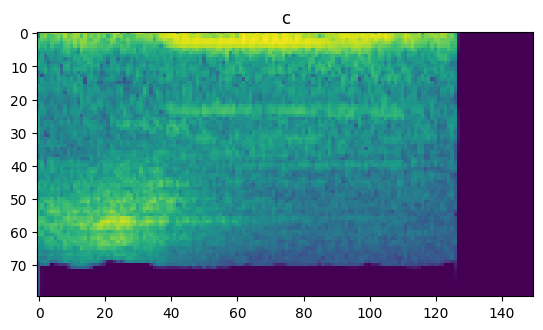

In [31]:
plt.imshow(local_dataset[20][0].cpu())
plt.title(local_dataset.class2label[full_dataset[20][1].item()])

In [175]:
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

print(f"Train Size = {len(train_dataset)}")
print(f"Val Size = {len(val_dataset)}")

Train Size = 4160
Val Size = 1040


In [176]:
class_weights = full_dataset.class_count/sum(full_dataset.class_count)
class_weights=torch.tensor(class_weights,dtype=torch.float).cuda()

In [177]:
def compute_corrects(outputs, labels):
    # Convert model outputs to predicted class labels
    _, predicted = torch.max(outputs, dim=1)
    
    # Calculate the number of correct predictions
    correct = (predicted == torch.tensor(labels)).sum().item()
    
    return correct

In [194]:
import torch.optim as optim

learning_rate = 0.001
epochs = 500
batch_size = 8
NUM_CLASSES = 11

criterion = nn.CrossEntropyLoss(weight=class_weights,reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.0001)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

train_losses = []
val_losses = []
accuracies = []

best_accuracy = 0
best_weights = None

pbar = tqdm(total=epochs, desc='Training')
for epoch in range(epochs):
    model.train()
    train_loss = 0
    num_train_items = 0
    for data in train_dataloader:
        inputs, labels = data
        
        optimizer.zero_grad()
        outputs = model(inputs)['logits']
        loss = criterion(outputs, labels)
        num_train_items += labels.size()[0]
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
    model.eval()
    val_loss = 0
    epoch_corrects = 0
    num_val_items = 0
    with torch.no_grad():
        for data in val_dataloader:
            inputs, labels = data

            outputs = model(inputs)['logits']
            loss = criterion(torch.tensor(outputs), labels).cuda()
            epoch_corrects += compute_corrects(outputs, labels)
            num_val_items += labels.size()[0]
            val_loss += loss.item()
        
    train_losses.append(train_loss / num_train_items)
    val_losses.append(val_loss / num_val_items)
    accuracies.append(epoch_corrects/num_val_items)
    
    pbar.set_postfix({
        'Train': train_loss / num_train_items, 
        'Val': val_loss / num_val_items,
        'Acc': epoch_corrects/num_val_items
    })

    if epoch_corrects/num_val_items > best_accuracy:
        best_accuracy = epoch_corrects/num_val_items
        best_weights = model.state_dict()
    pbar.update(1)

Training:   0%|          | 0/500 [00:00<?, ?it/s]

/tmp/ipykernel_3559834/2633959975.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(torch.tensor(outputs), labels).cuda()
/tmp/ipykernel_3559834/3718500490.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  correct = (predicted == torch.tensor(labels)).sum().item()


In [179]:
param_size = 0
for param in model.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2
print('model size: {:.3f}MB'.format(size_all_mb))

model size: 332.868MB


In [180]:
torch.save(best_weights, f'whisper_new/whisper_small_150_best_acc.npz')

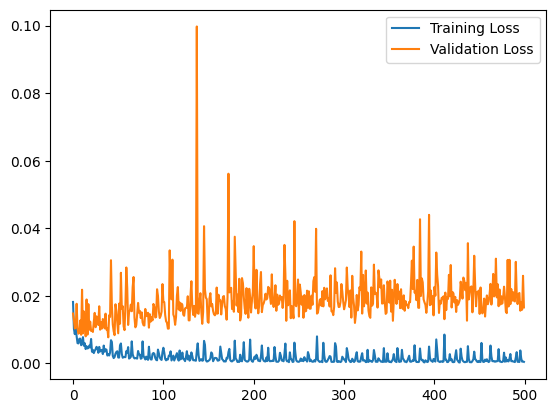

6.334954705584096


In [181]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.show()
print(best_loss)

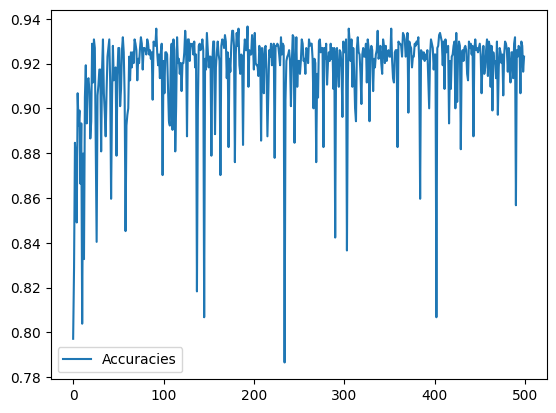

In [182]:
plt.plot(accuracies, label='Accuracies')
plt.legend()
plt.show()

In [185]:
import pickle 
with open(f'whisper_new/train_losses_whisper_small_150'+'.pkl', 'wb') as f:
      pickle.dump(train_losses, f)
with open(f'whisper_new/val_losses_whisper_small_150'+'.pkl', 'wb') as f:
      pickle.dump(val_losses, f)
with open(f'whisper_new/accuracies_whisper_small_150'+'.pkl', 'wb') as f:
      pickle.dump(accuracies, f)

In [521]:
model.forward(torch.unsqueeze(val_dataset[1][0], dim=0))


SequenceClassifierOutput(loss=None, logits=tensor([[-1.6347, -1.8797, -4.4100, -3.3276, -1.2848, -3.3702, -3.1579, -1.4248,
         -1.9188, -1.6966,  3.6237]], device='cuda:0',
       grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [520]:
val_dataset[1][1]

tensor(0, device='cuda:0')

In [522]:
model

WhisperForAudioClassification(
  (encoder): WhisperEncoder(
    (conv1): Conv1d(80, 384, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv2): Conv1d(384, 384, kernel_size=(3,), stride=(2,), padding=(1,))
    (embed_positions): Embedding(75, 384)
    (layers): ModuleList(
      (0-3): 4 x WhisperEncoderLayer(
        (self_attn): WhisperAttention(
          (k_proj): Linear(in_features=384, out_features=384, bias=False)
          (v_proj): Linear(in_features=384, out_features=384, bias=True)
          (q_proj): Linear(in_features=384, out_features=384, bias=True)
          (out_proj): Linear(in_features=384, out_features=384, bias=True)
        )
        (self_attn_layer_norm): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
        (activation_fn): GELUActivation()
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (final_layer_norm): LayerNorm((384,), eps=1e-05, elementwise_affine

In [541]:
compute_corrects(torch.tensor([[0, 0, 1], [0, 1, 0]]), torch.tensor([2, 1]))

C:\Users\iraha\AppData\Local\Temp\ipykernel_34408\3718500490.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  correct = (predicted == torch.tensor(labels)).sum().item()


2